# 分散学習のエミュレーション

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/distributed.ipynb)

MIMO.ipynbの学習問題を分散的に学習を行う。

* マスタと複数のワーカが協調して学習を行う
* ワーカはローカルデータセットで学習プロセスを実行し、更新されたパラメータをマスタに送る
* マスタではワーカから送られたパラメータの平均を計算し、その結果を各ワーカに配布する
* このプログラムで本当の分散計算をしているのではありません。分散計算をエミュレートしています。

## 必要なパッケージのインポート

In [1]:
import torch # テンソル計算など
import torch.nn as nn  # ネットワーク構築用
import torch.optim as optim  # 最適化関数
import matplotlib.pyplot as plt

## グローバル定数の設定

In [2]:
mbs = 500 # ミニバッチサイズ
noise_std = 0.5 # 通信路において重畳される加法的白色ガウス雑音の標準偏差 (\sigma)
n = 4 # アンテナ数
h = 30 # 隠れ層のユニット数
H = torch.normal(mean=torch.zeros(n, n), std=1.0) # 干渉行列
sgd_lr = 0.5 # SGDの学習率

## ネットワークの定義

In [3]:
class Net(nn.Module): # nn.Module を継承
    def __init__(self): # コンストラクタ
        super(Net, self).__init__()
        self.detector = nn.Sequential(
            nn.Linear(n, h),  # W_1, b_1,
            nn.ReLU(), # 活性化関数としてReLUを利用
            nn.Linear(h, h), # W_2, b_2
            nn.ReLU(),
            nn.Linear(h, n)  # W_3, b_3
        )
    def forward(self, x): # 推論計算をforwardに書く
        x = self.detector(x)
        x = torch.tanh(x) # x \in {+1,-1}^4 なので、最終層はtanhを利用
        return x

## ミニバッチ生成関数

In [4]:
def gen_minibatch():
    x = 1.0 - 2.0 * torch.randint(0, 2, (mbs, n)) # 送信ベクトル x をランダムに生成
    x = x.float()
    w = torch.normal(mean=torch.zeros(mbs, n), std = noise_std) # 加法的白色ガウス雑音の生成
    y = torch.mm(x, H.t()) + w
    return x, y

## ワーカ訓練用の関数

In [5]:
loss_func = nn.MSELoss() # 損失関数の指定(二乗損失関数)
def train(id):
    for i in range(num_itr):
        x, y = gen_minibatch() # ミニバッチの生成
        worker[id].zero_grad()  # オプティマイザの勾配情報初期化
        estimate = worker[id](y)  # 推論計算
        loss = loss_func(x, estimate)  # 損失値の計算
        loss.backward()  # 誤差逆伝播法(後ろ向き計算の実行)
        for param in worker[id].parameters(): # 学習可能パラメータの更新(オプティマイザを利用しない場合)
            param.data -= sgd_lr * param.grad.data

## マスタにおいてワーカのパラメータの平均とる

In [6]:
def aggregate_and_average(): 
    global d_index
    for i in range(num_workers):
        if i == 0:
            sum_vec = torch.nn.utils.parameters_to_vector(worker[0].parameters())
        else:
            sum_vec += torch.nn.utils.parameters_to_vector(worker[i].parameters())
    nn.utils.vector_to_parameters(sum_vec / num_workers, master.parameters())
    # 損失値の評価
    x, y = gen_minibatch() # ミニバッチの生成
    estimate = master(y)  # 推論計算
    loss = loss_func(x, estimate)  # 損失値の計算
    d_index += num_itr
    d_index_list.append(d_index)
    d_loss_list.append(loss.item())
    if d_index % 100 == 0:
        print(d_index, loss.item())

## マスタのパラメータをワーカに分配する

In [7]:
def distribute_parameters():
    master_param_vec = nn.utils.parameters_to_vector(master.parameters())
    for i in range(num_workers):
        nn.utils.vector_to_parameters(master_param_vec, worker[i].parameters())

## 分散トレーニングのループ
* 各ワーカでの計算は並列に行われていると仮定して、反復ステップ(d_index)を計算しています。
* パラメータの送受にかかる時間は0と仮定しています。

100 0.09879548102617264
200 0.10629915446043015
300 0.06760198622941971
400 0.07789934426546097
500 0.05392302945256233
600 0.05654444918036461
700 0.05984576791524887
800 0.06229083985090256
900 0.058557283133268356
1000 0.037922658026218414
100 0.06007644906640053
200 0.060099050402641296
300 0.07041825354099274
400 0.04144278168678284
500 0.04403972625732422
600 0.045493025332689285
700 0.040573734790086746
800 0.055083174258470535
900 0.06534223258495331
1000 0.037099409848451614


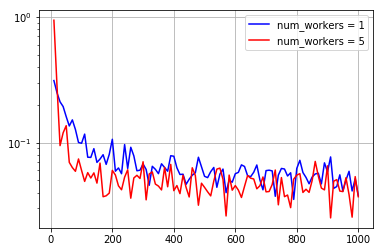

In [8]:
num_itr = 10

#### num_workers = 1
num_workers = 1
 
d_index_list = []
d_loss_list = []
d_index = 0

# ワーカとマスタのインスタンスを作成
worker = [0] * num_workers
for i in range(num_workers):
    worker[i] = Net()      
master = Net()

#分散トレーニングループ
for loop in range(1000//num_itr):
    for i in range(num_workers):
        train(i) # 各ワーカのトレーニングを行う
    aggregate_and_average() # マスタにパラメータを集約・平均
    distribute_parameters() # 各ワーカにパラメータを分配

# 損失関数値の表示    
plt.grid()
plt.yscale('log')
plt.plot(d_index_list, d_loss_list, color="blue", label='num_workers = 1')


#### num_workers = 5
num_workers = 5
 
d_index_list = []
d_loss_list = []
d_index = 0

# ワーカとマスタのインスタンスを作成
worker = [0] * num_workers
for i in range(num_workers):
    worker[i] = Net()      
master = Net()

#分散トレーニングループ
for loop in range(1000//num_itr):
    for i in range(num_workers):
        train(i) # 各ワーカのトレーニングを行う
    aggregate_and_average() # マスタにパラメータを集約・平均
    distribute_parameters() # 各ワーカにパラメータを分配

# 損失関数値の表示    
plt.grid()
plt.yscale('log')
plt.plot(d_index_list, d_loss_list, color="red", label='num_workers = 5')
plt.grid()
plt.legend()